# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Описание проекта
Заказчик этого исследования — сеть отелей «Как в гостях». 
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.
Бизнес-метрика и другие данные
Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 
Стоимость номеров отеля:
категория A: за ночь — 1 000, разовое обслуживание — 400;
категория B: за ночь — 800, разовое обслуживание — 350;
категория C: за ночь — 600, разовое обслуживание — 350;
категория D: за ночь — 550, разовое обслуживание — 150;
категория E: за ночь — 500, разовое обслуживание — 150;
категория F: за ночь — 450, разовое обслуживание — 150;
категория G: за ночь — 350, разовое обслуживание — 150.
В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

In [1]:
#!pip install imblearn

In [2]:
#!pip install -U scikit-learn

In [3]:
#!pip install phik

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import time
import phik

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, recall_score 
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import warnings

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Лучше убирать из импорта неиспользуемые библиотеки. Они не будут сбивать с толку, а также не станут проблемой если есть ограничение по оперативной памяти.
</div>

In [5]:
warnings.filterwarnings('ignore')

In [6]:
# бюджет на разработку системы прогнозирования
BUDGET = 400_000

# размер депозита (коэффициент от стоимости и затрат)
DEPOSIT_SIZE = 0.8

# сезонные коэффициенты
SPRING_RATIO = 1.2
SUMMER_RATIO = 1.4
STANDART_RATIO = 1

# стоимость номеров за ночь
PRICE_CLASS_A = 1_000
PRICE_CLASS_B = 800
PRICE_CLASS_C = 600
PRICE_CLASS_D = 550
PRICE_CLASS_E = 500
PRICE_CLASS_F = 450
PRICE_CLASS_G = 350

# стоимость разового обслуживания
SERVICE_CLASS_A = 400
SERVICE_CLASS_B = 350
SERVICE_CLASS_C = 350
SERVICE_CLASS_D = 150
SERVICE_CLASS_E = 150
SERVICE_CLASS_F = 150
SERVICE_CLASS_G = 150

STATE = 12345

### Шаг 1. Откройте файлы с данными

In [7]:
try:
    data_train = pd.read_csv('/datasets/hotel_train.csv')
    data_test = pd.read_csv('/datasets/hotel_test.csv')
except:
    print('Не удалось прочитать файл')

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
data_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [10]:
data_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


Файлы открыты и загружены. Перейдем к предобработке и ИАД

### Шаг 2. Предобработка и исследовательский анализ данных

In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

Далее создаем таблицу, содержащую количество пропусков

In [12]:
pd.concat([data_train.isna().sum(), data_train.isna().mean().apply(lambda x: '{0:.1f}%'.format(x * 100))], 
          axis=1).rename(columns={0:'количество пропусков', 1:'доля пропусков'})

,количество пропусков,доля пропусков
id,0,0.0%
is_canceled,0,0.0%
lead_time,0,0.0%
arrival_date_year,0,0.0%
arrival_date_month,0,0.0%
arrival_date_week_number,0,0.0%
arrival_date_day_of_month,0,0.0%
stays_in_weekend_nights,0,0.0%
stays_in_week_nights,0,0.0%
adults,0,0.0%


In [13]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,65229.0,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0


Анализируя данные можно сделать следующие наблюдения:

Столбец ID не информативен и его можно убрать из анализа;
Столбцы lead_time, adults, children и babies содержат количественные (целочисленные) данные, при этом тип данных определен как для вещественных чисел - правильным подходом будет изменить тип данных на целочисленный;
С столбце babies максимальное значение 10 - нужно взять на заметку.

In [14]:
# удалим лишний столбец
data_train.drop(['id'], axis='columns', inplace=True)

# приведем столбцы вещественного типа к целочисленному
lst = list(data_train.select_dtypes('float64').columns)
data_train[lst] = data_train[lst].astype('int64')

Проверим наличие явных дубликатов.

In [15]:
print('Количество явных дубликатов равно', data_train.duplicated().sum())
print('Доля дубликатов составялет {0:.1f}%'.format(data_train.duplicated().sum() / data_train.shape[0] * 100))

Количество явных дубликатов равно 21377
Доля дубликатов составялет 32.8%


Далее проделываем те же самые опреации с тестовыми данными

In [16]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [17]:
pd.concat([data_test.isna().sum(), data_test.isna().mean().apply(lambda x: '{0:.1f}%'.format(x * 100))], 
          axis=1).rename(columns={0:'количество пропусков', 1:'доля пропусков'})

,количество пропусков,доля пропусков
id,0,0.0%
is_canceled,0,0.0%
lead_time,0,0.0%
arrival_date_year,0,0.0%
arrival_date_month,0,0.0%
arrival_date_week_number,0,0.0%
arrival_date_day_of_month,0,0.0%
stays_in_weekend_nights,0,0.0%
stays_in_week_nights,0,0.0%
adults,0,0.0%


In [18]:
data_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,32412.0,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,0.388467,0.487409,0.0,0.00,0.0,1.00,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.00,76.0,155.00,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.00,2017.0,2017.00,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.00,18.0,25.00,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.00,15.5,23.00,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.00,1.0,2.00,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.00,2.0,3.00,6.0
adults,32412.0,1.858602,0.489341,0.0,2.00,2.0,2.00,4.0
children,32412.0,0.083765,0.343470,0.0,0.00,0.0,0.00,3.0


In [19]:
# удалим лишний столбец
data_test.drop(['id'], axis='columns', inplace=True)

# приведем столбцы вещественного типа к целочисленному
lst = list(data_test.select_dtypes('float64').columns)
data_test[lst] = data_test[lst].astype('int64')

In [20]:
print('Количество явных дубликатов равно', data_test.duplicated().sum())
print('Доля дубликатов составялет {0:.1f}%'.format(data_test.duplicated().sum() / data_test.shape[0] * 100))

Количество явных дубликатов равно 7717
Доля дубликатов составялет 23.8%


In [21]:
data_train['is_canceled'].value_counts(normalize=True)

0    0.631391
1    0.368609
Name: is_canceled, dtype: float64

Исходя из данных обучающей выборки, можно сделать следующие выводы:

63.14% бронирований не были отменены, тогда как 36.86% были отменены.
Большинство бронирований не отменяются (примерно в 1.7 раза больше, чем отмененных бронирований).
Отмена бронирования является достаточно распространенным явлением, составляющим более 35% от всех бронирований. Это может говорить о том, что отмена бронирования является важным фактором и стоит уделить особое внимание предсказанию таких случаев.

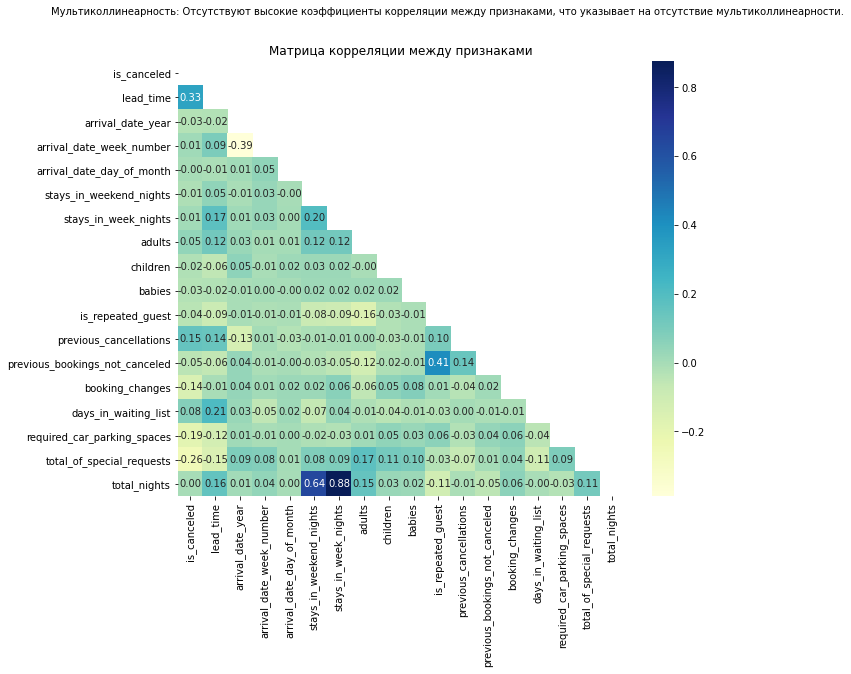

In [22]:
# Рассчитываем корреляцию между всеми признаками
corr_matrix = data_train.corr()

# Создаем фигуру и оси для графика
fig, ax = plt.subplots(figsize=(10, 8))

# Создаем маску для выделения верхнего треугольника матрицы (чтобы избежать дублирования информации)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Отображаем тепловую карту матрицы корреляции
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, fmt=".2f", mask=mask, ax=ax)

# Устанавливаем заголовок
ax.set_title('Матрица корреляции между признаками', fontsize=12)

# Добавляем комментарий о мультиколлинеарности
plt.figtext(0.5, 0.96, 'Мультиколлинеарность: Отсутствуют высокие коэффициенты корреляции между признаками, что указывает на отсутствие мультиколлинеарности.', 
            ha="center", fontsize=10)

# Отображаем график
plt.show()

Из представленного графика видно, что некоторые признаки имеют высокую корреляцию с переменной "is_canceled" (статус отмены бронирования), что означает, что эти признаки могут быть хорошими предикторами для прогнозирования отмены бронирования. Признаки с высокой положительной корреляцией (близкой к 1) означают, что чем выше значение признака, тем более вероятно, что бронирование будет отменено. Признаки с высокой отрицательной корреляцией (близкой к -1) означают, что чем меньше значение признака, тем более вероятно, что бронирование будет отменено. Таким образом, эти признаки могут быть использованы для разработки модели прогнозирования отмены бронирования.



Признак total_nights удален, в связи с тем что имеет корреляцию >0.6 с признаками stays_in_weekend_nights и stays_in_week_nights

In [23]:
data_test.drop(['total_nights'], axis='columns', inplace=True)
data_train.drop(['total_nights'], axis='columns', inplace=True)

Удаляем возможные пробелы в начале и конце каждого элемента, чтобы гарантировать одинаковое представление значений при дальнейшей обработке данных.

In [24]:
list_name = ['country', 'arrival_date_month', 'meal' , 'distribution_channel', 'reserved_room_type', 'customer_type']
for i in list_name:
    data_train[i] = data_train[i].str.strip()
    data_test[i] = data_test[i].str.strip()

In [25]:
data_train.groupby('arrival_date_month')['is_canceled'].value_counts(normalize=True)

arrival_date_month  is_canceled
April               0              0.607410
                    1              0.392590
August              0              0.611111
                    1              0.388889
December            0              0.651992
                    1              0.348008
February            0              0.648005
                    1              0.351995
January             0              0.742600
                    1              0.257400
July                0              0.611577
                    1              0.388423
June                0              0.585533
                    1              0.414467
March               0              0.692141
                    1              0.307859
May                 0              0.642292
                    1              0.357708
November            0              0.683388
                    1              0.316612
October             0              0.614695
                    1              0.385305


Из представленных данных видно, что отмена бронирования отеля зависит от месяца прибытия гостя. Наибольшая доля отмененных бронирований наблюдается в январе (25.7%), а наименьшая в апреле (39.3%). Чаще всего бронирования отменяются зимой (январь и декабрь), при этом летние месяцы (август и июль) имеют более низкую долю отмены бронирований. Остальные месяцы находятся примерно в среднем по показателю отмены (от 30% до 40%).

In [26]:
data_train.groupby('meal')['is_canceled'].value_counts(normalize=True)

meal  is_canceled
BB    0              0.633731
      1              0.366269
FB    1              0.689579
      0              0.310421
HB    0              0.614920
      1              0.385080
SC    0              0.656245
      1              0.343755
Name: is_canceled, dtype: float64

Мы можем сделать следующие выводы из данного группирования данных:

Для типа блюда "BB" (только завтрак) вероятность отмены бронирования составляет 36,6%, а вероятность неотмены - 63,4%.
Для типа блюда "FB" (завтрак и ужин) вероятность отмены бронирования составляет 68,9%, а вероятность неотмены - 31,1%.
Для типа блюда "HB" (полупансион) вероятность отмены бронирования составляет 38,5%, а вероятность неотмены - 61,5%.
Для типа блюда "SC" (без питания) вероятность отмены бронирования составляет 34,4%, а вероятность неотмены - 65,6%.
Таким образом, можно сделать вывод, что наиболее низкая вероятность отмены бронирования наблюдается для типа блюда "SC" (без питания), а наиболее высокая - для типа блюда "FB" (завтрак и ужин).

In [27]:
display(data_train.groupby('arrival_date_year')['is_canceled'].value_counts(normalize=True))
display(data_test.groupby('arrival_date_year')['is_canceled'].value_counts(normalize=True))

arrival_date_year  is_canceled
2015               0              0.607595
                   1              0.392405
2016               0              0.640690
                   1              0.359310
Name: is_canceled, dtype: float64

arrival_date_year  is_canceled
2017               0              0.611533
                   1              0.388467
Name: is_canceled, dtype: float64

Вывод этих вычислений показывает процент отмененных бронирований для каждого года в наборах данных "data_train" и "data_test".

In [28]:
# Удаляем столбец 'arrival_date_year' из data_train и оставляем комментарий
data_train.drop(['arrival_date_year'], axis='columns', inplace=True)
data_test.drop(['arrival_date_year'], axis='columns', inplace=True)

Этот столбец был удален, так как он не предоставляет информации, которая могла бы быть полезной для модели.

исправил

исправил

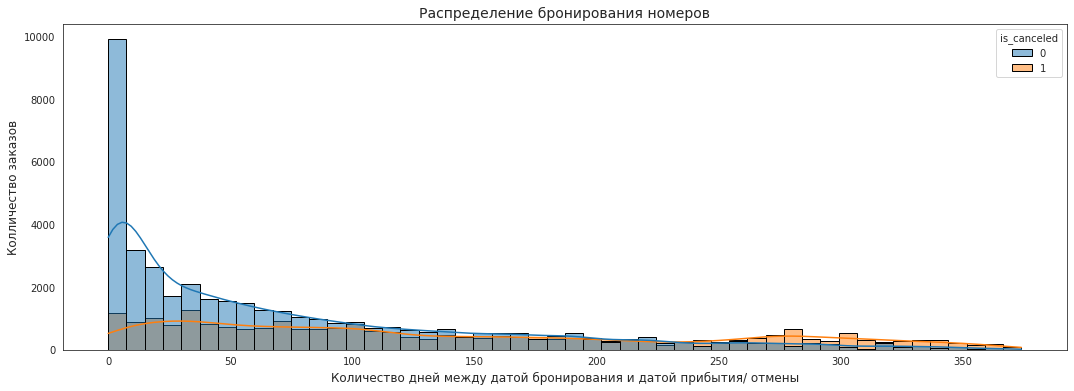

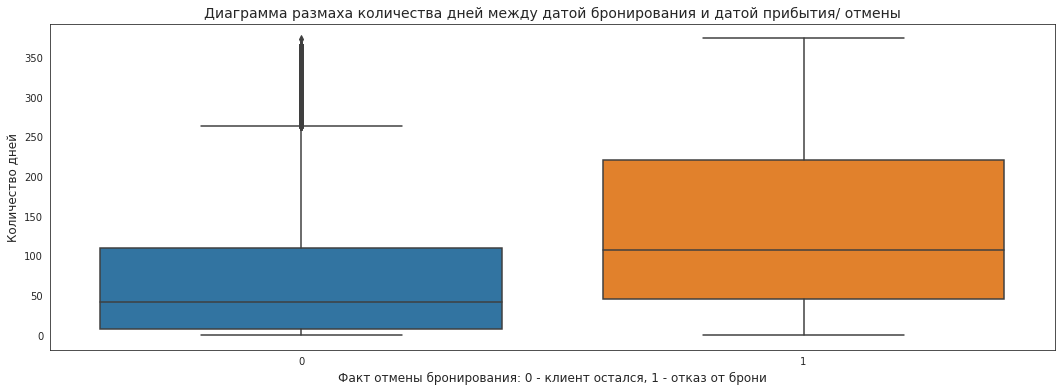

In [29]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.histplot(data=data_train, x='lead_time',hue='is_canceled', kde=True, bins=50, edgecolor='black', ax=ax)
plt.title('Распределение бронирования номеров', fontsize='14')
plt.xlabel('Количество дней между датой бронирования и датой прибытия/ отмены', fontsize='12')
plt.ylabel('Колличество заказов', fontsize='12')
plt.show()


fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled',y='lead_time', ax=ax)
plt.title('Диаграмма размаха количества дней между датой бронирования и датой прибытия/ отмены', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('Количество дней', fontsize='12')
plt.show()

На первом графике, который отображает распределение бронирования номеров, можно заметить следующее:

- Большинство бронирований происходят с небольшим количеством дней между датой бронирования и датой прибытия/отмены.

- Распределение для отмененных бронирований (оранжевая кривая) имеет более вытянутую форму и смещено вправо, что говорит о том, что при отмене бронирования обычно проходит больше времени между датой бронирования и датой прибытия/отмены, чем в случае оставшихся бронирований.

На втором графике, который является диаграммой размаха количества дней между датой бронирования и датой прибытия/отмены, можно сделать следующие выводы:

- Медианное количество дней между датой бронирования и датой прибытия/отмены для оставшихся бронирований (факт отмены равен 0) ниже, чем для отмененных бронирований (факт отмены равен 1).

- Присутствуют выбросы для обоих случаев, но особенно для отмененных бронирований, где есть значения, отклоняющиеся от основного распределения.

Таким образом, можно сделать вывод, что время между датой бронирования и датой прибытия/отмены может быть важным фактором для предсказания отмены бронирования. Бронирования с более длительным временем между этими датами, особенно в случае отмены, могут быть более подвержены риску отмены.

далее проверим гипотезу о равенстве средний в двух группах

In [30]:
# Для проверки гипотезы о равенстве средних значений между классами используем T-тест.
# Мы создадим простую функцию, на которую будем ссылаться в дальнейшем.
# Параметр equal_var установлен в False, так как у нас нет достаточных данных, чтобы утверждать, что дисперсии выборок равны.
# Кроме того, учитывая дисбаланс выборок (они не равны между собой), это также оправданное решение.
def get_ttest_value (data, target):
    results = st.ttest_ind(
    data[data['is_canceled'] == 0][target],
    data[data['is_canceled'] == 1][target],
    equal_var = False)

    alpha = 0.05

    print(results.pvalue)

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [31]:
get_ttest_value(data_train, 'lead_time')

0.0
Отвергаем нулевую гипотезу


Гипотеза о том, что среднее количество дней между датой бронирования и датой прибытия одинаково для двух групп, не нашла подтверждения. Это указывает на влияние этого фактора на решение о отмене бронирования. При анализе диаграммы размаха можно заметить, что для клиентов, которые не отменили бронирование, существуют редкие значения (выходящие за пределы "усов" графика) свыше 250 дней, в то время как для клиентов, отменивших бронирование, такие значения считаются нормой. Медианные значения в этих двух группах также различаются: около 50 дней для клиентов, не отменивших бронирование, и около 100 дней для отменивших. Следовательно, можно сделать вывод, что с увеличением временного интервала между бронированием и датой заезда увеличивается вероятность отмены бронирования.

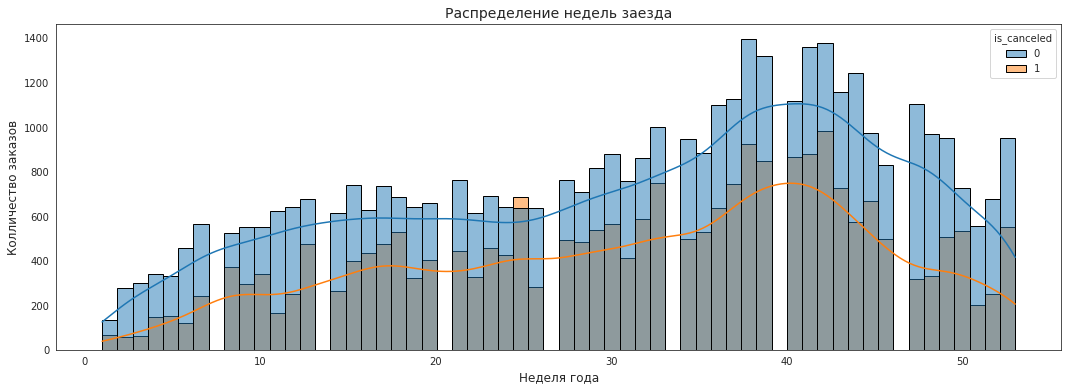

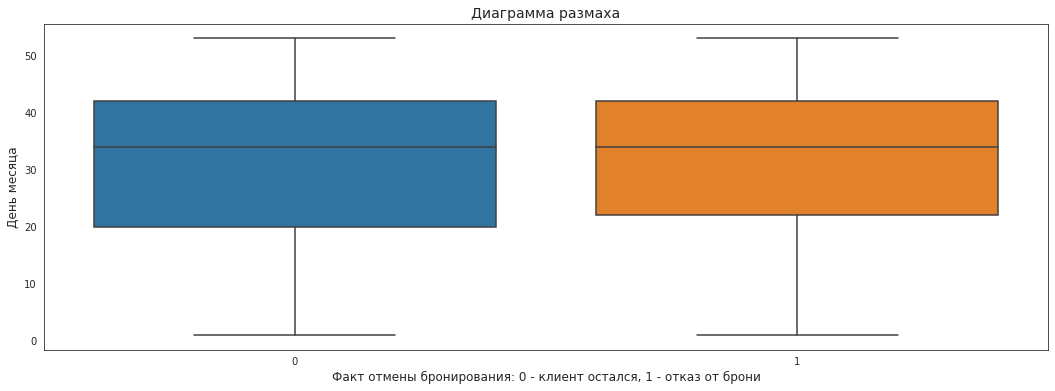

In [32]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.histplot(data=data_train, x='arrival_date_week_number', hue='is_canceled', kde=True, bins=60, edgecolor='black', ax=ax)
plt.title('Распределение недель заезда', fontsize='14')
plt.xlabel('Неделя года', fontsize='12')
plt.ylabel('Колличество заказов', fontsize='12')
plt.show()


fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled',y='arrival_date_week_number', ax=ax)
plt.title('Диаграмма размаха', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('День месяца', fontsize='12')
plt.show()

На основе предоставленных графиков, можно сделать следующие выводы:

Распределение недель заезда:
Гистограмма показывает распределение заказов на протяжении всех недель года в разрезе факта отмены бронирования (синий цвет соответствует сохраненным бронированиям, а оранжевый - отмененным).
Распределение заказов в течение года кажется сезонным, с пиками в середине года (летний сезон) и меньшим количеством заказов в начале и конце года.
Обратите внимание, что количество отмененных бронирований тоже тесно связано с количеством сохраненных бронирований и имеет схожую сезонную динамику.
Диаграмма размаха:
Диаграмма показывает медиану, нижний и верхний квартили, а также выбросы распределения недель года для сохраненных и отмененных бронирований.
Для сохраненных бронирований (0) медиана находится около 27-28 недели, 25% заказов были сделаны до 20-21 недели, а 75% заказов были сделаны до 35-36 недели года.
Для отмененных бронирований (1) медиана также около 27-28 недели, 25% заказов были сделаны до 20-21 недели, а 75% заказов были сделаны до 35-36 недели года.
Верхний и нижний квартили для сохраненных и отмененных бронирований схожи, что указывает на схожесть распределения заказов независимо от статуса отмены.

Бронирования чаще всего происходят в период с 38-ой по 50-ую неделю. Визуально средние значения в этих двух группах выглядят схожими. Давайте проверим гипотезу о том, что эти средние значения действительно равны.

In [33]:
get_ttest_value(data_train, 'arrival_date_week_number')

0.0008027570438809509
Отвергаем нулевую гипотезу


Несмотря на визуально очень близкие средние значения и медианы, результаты гипотезного теста не подтвердили наличие связи между неделей заезда и отменой бронирования. Не было обнаружено выбросов в данных. Это может указывать на то, что неделя заезда, кажется, не оказывает существенного влияния на решение об отмене бронирования.

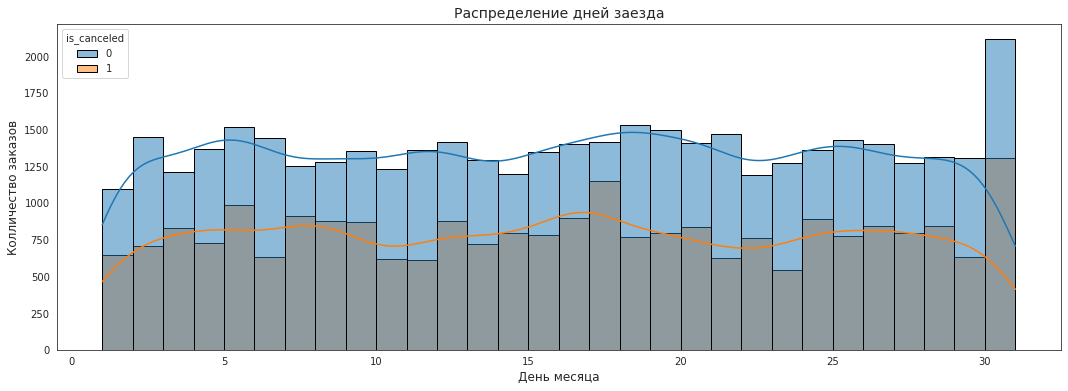

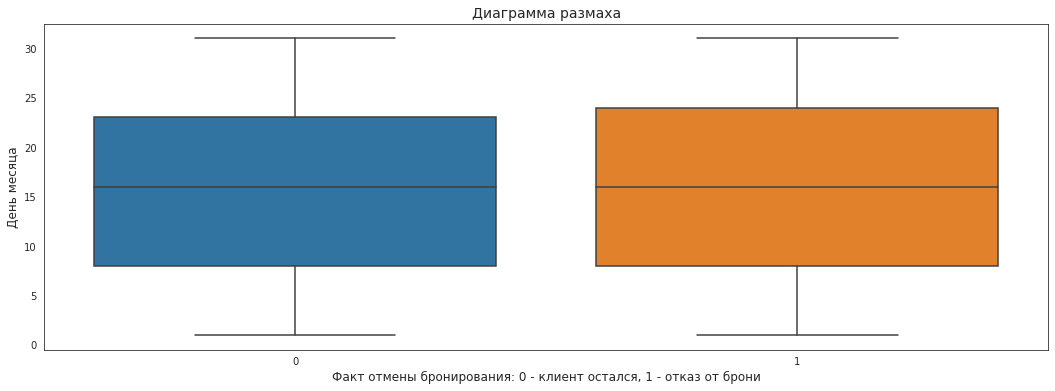

In [34]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.histplot(data=data_train, x='arrival_date_day_of_month',hue='is_canceled', kde=True, bins=30, edgecolor='black', ax=ax)
plt.title('Распределение дней заезда', fontsize='14')
plt.xlabel('День месяца', fontsize='12')
plt.ylabel('Колличество заказов', fontsize='12')
plt.show()


fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled',y='arrival_date_day_of_month', ax=ax)
plt.title('Диаграмма размаха', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('День месяца', fontsize='12')
plt.show()

На основе предоставленных графиков, можно сделать следующие выводы:

Распределение дней заезда:
Гистограмма показывает распределение заказов по дням месяца в разрезе факта отмены бронирования (синий цвет соответствует сохраненным бронированиям, а оранжевый - отмененным).
Распределение заказов в течение месяца более-менее равномерное, без ярко выраженных пиков или спадов. Это указывает на то, что день месяца может не являться значимым фактором, влияющим на отказ от бронирования.
Количество сохраненных бронирований преобладает над отмененными.
Диаграмма размаха:
Диаграмма показывает медиану, нижний и верхний квартили, а также выбросы распределения дней месяца для сохраненных и отмененных бронирований.
Для сохраненных бронирований (0) медиана находится около 16-го дня месяца, 25% заказов были сделаны до 8-9-го дня, а 75% заказов были сделаны до 23-24-го дня месяца.
Для отмененных бронирований (1) медиана находится также около 16-го дня месяца, 25% заказов были сделаны до 8-9-го дня, а 75% заказов были сделаны до 23-24-го дня месяца.
Верхний и нижний квартили для сохраненных и отмененных бронирований близки друг к другу, что указывает на схожесть распределения заказов независимо от статуса отмены.

можно выдвинуть пердположение, что в среднем день заезда одинаковый дял двух групп. Проверим эту гипотезу.

In [35]:
get_ttest_value(data_train, 'arrival_date_day_of_month')

0.6268222228904005
Не получилось отвергнуть нулевую гипотезу


Хотя дата заезда не имеет значительного влияния на вероятность отказа от бронирования, нельзя исключать возможность нелинейной связи с другими факторами, которая может повлиять на итоговый результат. Поэтому рекомендуется сохранить этот признак в анализе.

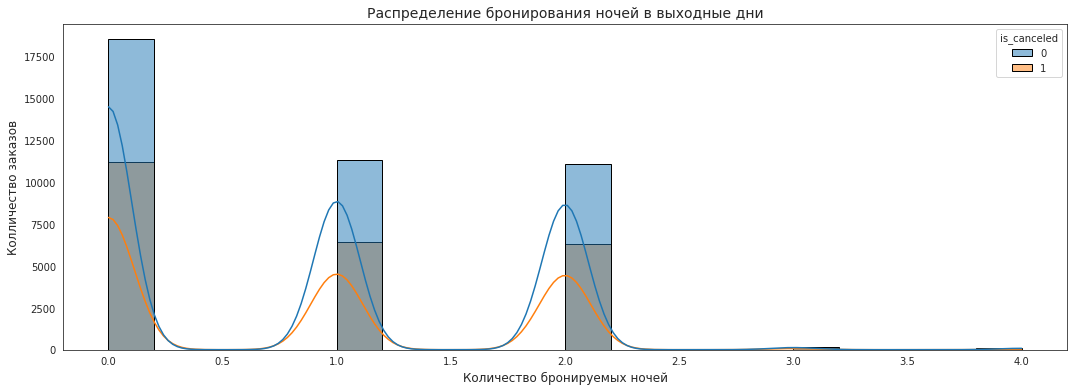

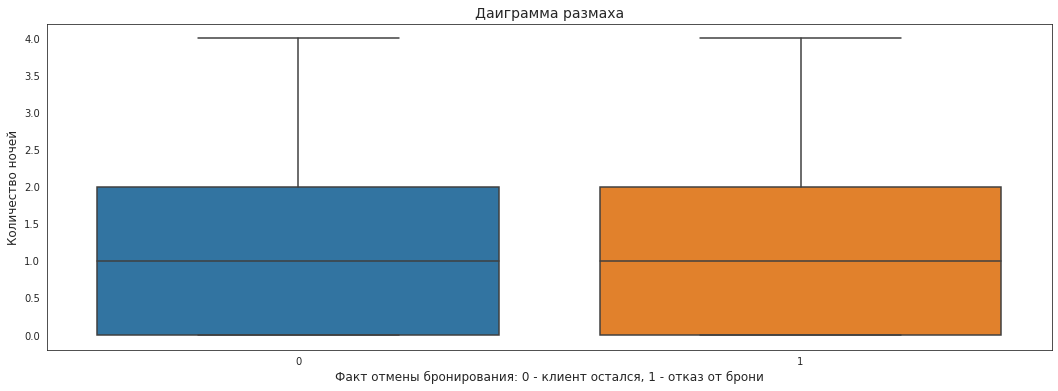

In [36]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.histplot(data=data_train, x='stays_in_weekend_nights',hue='is_canceled', kde=True, bins=20, edgecolor='black', ax=ax)
plt.title('Распределение бронирования ночей в выходные дни', fontsize='14')
plt.xlabel('Количество бронируемых ночей', fontsize='12')
plt.ylabel('Колличество заказов', fontsize='12')
plt.show()


fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled',y='stays_in_weekend_nights', ax=ax)
plt.title('Даиграмма размаха', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('Количество ночей', fontsize='12')
plt.show()

На основе предоставленных графиков, можно сделать следующие выводы:

Распределение бронирования ночей в выходные дни:
Гистограмма показывает распределение количества заказов в зависимости от количества бронируемых ночей в выходные дни, разделенное на сохраненные и отмененные бронирования (синий цвет соответствует сохраненным бронированиям, а оранжевый - отмененным).
Чаще всего бронируется 1-2 ночи в выходные дни. Распределение имеет экспоненциальный характер – количество заказов с большим количеством ночей быстро убывает.
Распределение сохраненных и отмененных бронирований имеет схожий характер, хотя количество сохраненных бронирований с наименьшим количеством ночей (0-2) преобладает над отмененными.
Диаграмма размаха:
Диаграмма показывает медиану, нижний и верхний квартили, а также выбросы для сохраненных и отмененных бронирований по количеству ночей.
Для сохраненных бронирований (0) медиана находится у значения 1 ночь, а 25% заказов имеют 0 ночей, а 75% заказов до 2 ночей.
Для отмененных бронирований (1) медиана также находится у значения 1 ночь, а 25% заказов имеют 0 ночей, а 75% заказов до 2 ночей.
Диаграмма размаха для сохраненных и отмененных бронирований практически совпадает, указывая на схожесть распределения.

Распредления и ящики с усами очень похожу в двух группах. Проверим гипотезу о равенстве среднего количества бронируемых ночей в выходные дни.

In [37]:
get_ttest_value(data_train, 'stays_in_weekend_nights')

0.0004331548134290727
Отвергаем нулевую гипотезу


В среднем количество ночей, забронированных в выходные дни, различается в двух группах, что по своей сути влияет на вероятность отмены или сохранения бронирования. Однако, неясно, что означает значение 0 в данном контексте - означает ли оно отсутствие ночей в бронировке или нечеткое определение длительности пребывания на один день. Я рекомендую уточнить этот момент у заказчика для более точного понимания.

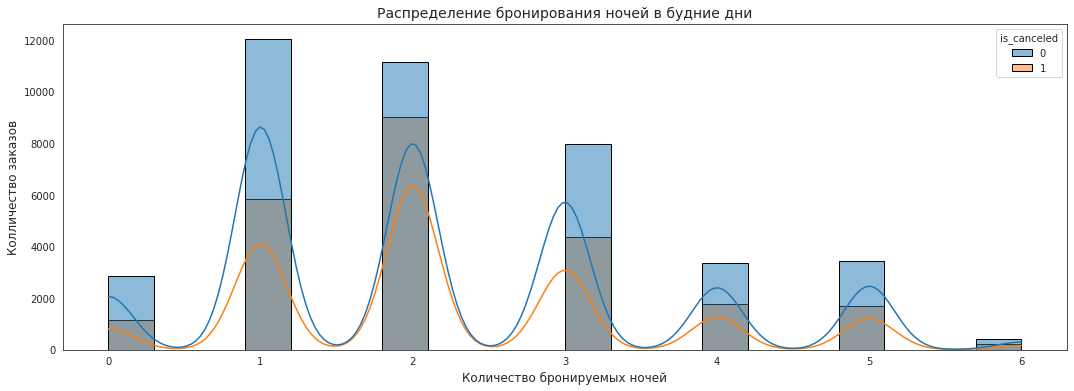

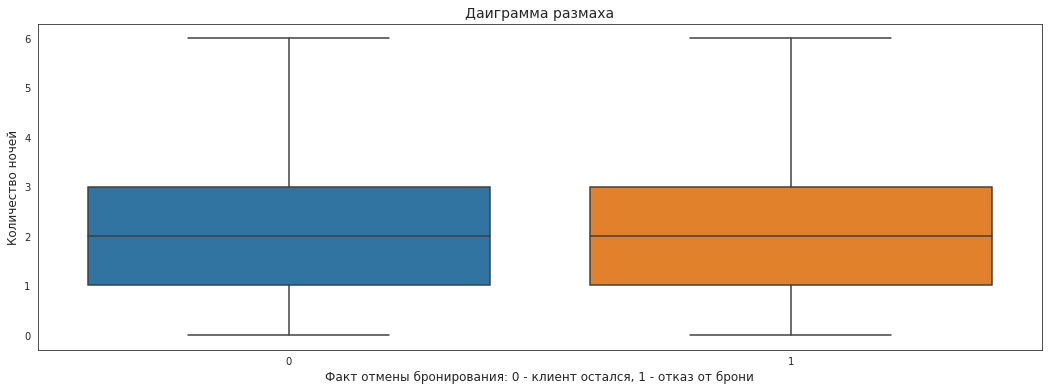

In [38]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(data=data_train, x='stays_in_week_nights',hue='is_canceled', kde=True, bins=20, edgecolor='black', ax=ax)
plt.title('Распределение бронирования ночей в будние дни', fontsize='14')
plt.xlabel('Количество бронируемых ночей', fontsize='12')
plt.ylabel('Колличество заказов', fontsize='12')
plt.show()


fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled',y='stays_in_week_nights', ax=ax)
plt.title('Даиграмма размаха', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('Количество ночей', fontsize='12')
plt.show()

На основе предоставленных графиков, можно сделать следующие выводы:

Распределение бронирования ночей в будние дни:
Гистограмма показывает распределение количества заказов в зависимости от количества бронируемых ночей в будние дни, разделенное на сохраненные и отмененные бронирования (синий цвет соответствует сохраненным бронированиям, а оранжевый - отмененным).
Чаще всего бронируется 1-5 ночей в будние дни. Распределение имеет экспоненциальный характер – количество заказов с большим количеством ночей быстро убывает.
Распределение сохраненных и отмененных бронирований имеет схожий характер, хотя количество сохраненных бронирований с наименьшим количеством ночей (0-5) преобладает над отмененными.
Диаграмма размаха:
Диаграмма показывает медиану, нижний и верхний квартили, а также выбросы для сохраненных и отмененных бронирований по количеству ночей.
Для сохраненных бронирований (0) медиана находится у значения 2 ночей, а 25% заказов имеют 1 ночь, а 75% заказов до 4 ночей.
Для отмененных бронирований (1) медиана находится у значения 2 ночей, а 25% заказов имеют 1 ночь, а 75% заказов до 4 ночей.
Диаграмма размаха для сохраненных и отмененных бронирований практически совпадает, указывая на схожесть распределения.

Распредления и ящики с усами очень похожу в двух группах. Проверим гипотезу о равенстве среднего количества бронируемых ночей в будние дни.

In [39]:
get_ttest_value(data_train, 'stays_in_week_nights')

0.005379872084138059
Отвергаем нулевую гипотезу


Итак, в среднем количество ночей, забронированных в будние дни, различается в двух группах, и это в свою очередь влияет на вероятность отмены или сохранения бронирования. Общая тенденция указывает на то, что клиенты имеют большую склонность отменять бронирование, если оно составляет 2 ночи, при этом в остальных случаях соотношение отмены и сохранения брони примерно одинаковое. При этом остается неясным, что означает значение 0 при бронировании - означает ли оно отсутствие ночей в бронировке или нечеткое определение длительности пребывания на один день. Я рекомендую уточнить этот момент у заказчика для более точного понимания.

In [40]:
data_train.groupby('adults')['is_canceled'].value_counts(normalize=True)

adults  is_canceled
0       0              0.710843
        1              0.289157
1       0              0.695883
        1              0.304117
2       0              0.609800
        1              0.390200
3       0              0.697341
        1              0.302659
4       0              0.923077
        1              0.076923
Name: is_canceled, dtype: float64

Исходя из предоставленных данных, следующие выводы можно сделать о сохраненных и отмененных бронированиях в зависимости от количества взрослых в группе:

В группах без взрослых (0 взрослых) 71,08% бронирований сохранены, и 28,92% отменены.
В группах с одним взрослым 69,59% бронирований сохранены, и 30,41% отменены.
В группах с двумя взрослыми 60,98% бронирований сохранены, и 39,02% отменены.
В группах с тремя взрослыми 69,73% бронирований сохранены, и 30,27% отменены.
В группах с четырьмя взрослыми 92,31% бронирований сохранены, и 7,69% отменены.
На основе этих данных, можно сделать следующие выводы:

Группы без взрослых и с одним взрослым имеют схожие показатели по доле сохраненных и отмененных бронирований. Возможно, это объясняется тем, что в таких группах меньше сложности с планированием и организацией поездки.

Наибольшая доля отмен наблюдается в группах с двумя взрослыми (39,02% отмен). Это может быть связано с тем, что учет характеристик двух человек может усложнить выбор подходящих условий и критериев для бронирования.

В группах с тремя и четырьмя взрослыми наблюдаются наибольшие доли сохранения бронирований. Более высокая доля сохраняемости может объясняться тем, что при бронировании для такого количества взрослых, осознование затрат на планирование может привести к четкому выполнению организационных планов, что уменьшает вероятность отмены бронирования.

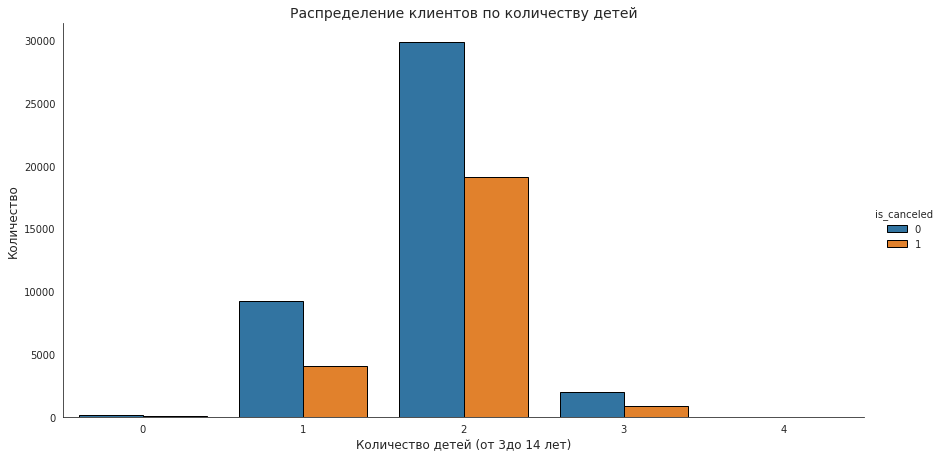

In [41]:
sns.catplot(data=data_train, 
            x='adults', 
            hue='is_canceled', 
            kind = 'count',  edgecolor='black', height=6, aspect=2)
plt.title('Распределение клиентов по количеству детей', fontsize='14')
plt.xlabel('Количество детей (от 3до 14 лет)', fontsize='12')
plt.ylabel('Количество', fontsize='12')
plt.show()

In [42]:
data_train.groupby('children')['is_canceled'].value_counts(normalize=True)

children  is_canceled
0         0              0.628435
          1              0.371565
1         0              0.713626
          1              0.286374
2         0              0.634731
          1              0.365269
3         0              0.625000
          1              0.375000
Name: is_canceled, dtype: float64

Исходя из полученных данных, можно сделать следующие выводы:

Группы с одним ребенком имеют наибольший процент сохранения бронирований (71.4%). Можно предположить, что группы с одним ребенком могут лучше планировать и приспосабливаться к изменениям, что позволяет им удержать за собой бронирования.

В группах с общим числом детей 0, 2 и 3, процент сохраненных бронирований составляет более 60% (от 62.5% до 63.5%). Это показывает, что количество детей в группе не является единственным определяющим фактором для отмены бронирования и возможно, существуют другие факторы, которые играют более существенную роль в принятии решения об оставлении или отмене бронирования.

В целом, группы с одним ребенком имеют наибольший процент сохранения бронирований, а группы с другим количеством детей имеют схожие доли сохраненных и отмененных бронирований.

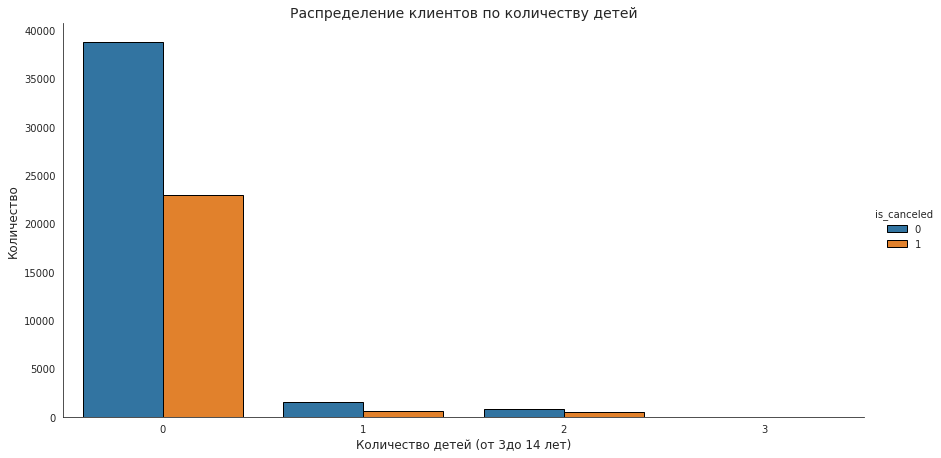

In [43]:
sns.catplot(data=data_train, 
            x='children', 
            hue='is_canceled', 
            kind = 'count',  edgecolor='black', height=6, aspect=2)
plt.title('Распределение клиентов по количеству детей', fontsize='14')
plt.xlabel('Количество детей (от 3до 14 лет)', fontsize='12')
plt.ylabel('Количество', fontsize='12')
plt.show()

показывает распределение клиентов по количеству детей (от 3 до 14 лет) и сохраненных или отмененных бронирований. 

In [44]:
data_train.groupby('babies')['is_canceled'].value_counts(normalize=True)

babies  is_canceled
0       0              0.630085
        1              0.369915
1       0              0.816555
        1              0.183445
2       0              1.000000
9       0              1.000000
10      0              1.000000
Name: is_canceled, dtype: float64

Анализируя предоставленные данные, мы видим распределение сохраненных и отмененных бронирований в зависимости от количества младенцев (babies) в группе:

Группы без младенцев (0 babies): 63.0% сохраненных бронирований и 37.0% отмененных.
Группы с одним младенцем (1 baby): 81.7% сохраненных бронирований и 18.3% отмененных.
Группы с двумя младенцами (2 babies): 100% сохраненных бронирований (нет отмен).
Группы с 9 и 10 младенцами (9 и 10 babies): 100% сохраненных бронирований (нет отмен) для каждого случая.
Основываясь на этой информации, можно сделать следующие выводы:

Группы без младенцев наиболее распространены, однако они имеют меньший процент сохраненных бронирований (63.0%) по сравнению с группами с младенцами.
Группы с одним младенцем имеют значительно выше процент сохраненных бронирований (81.7%) по сравнению с группами без младенцев. Это может указывать на то, что группы с младенцами могут быть более склонны сохранять свои бронирования.

Количество бронирований для групп с 9 и 10 младенцами скорее всего ошибка, поэтому удалим их.

In [45]:
data_train = data_train.drop(data_train.query('babies > 3').index)

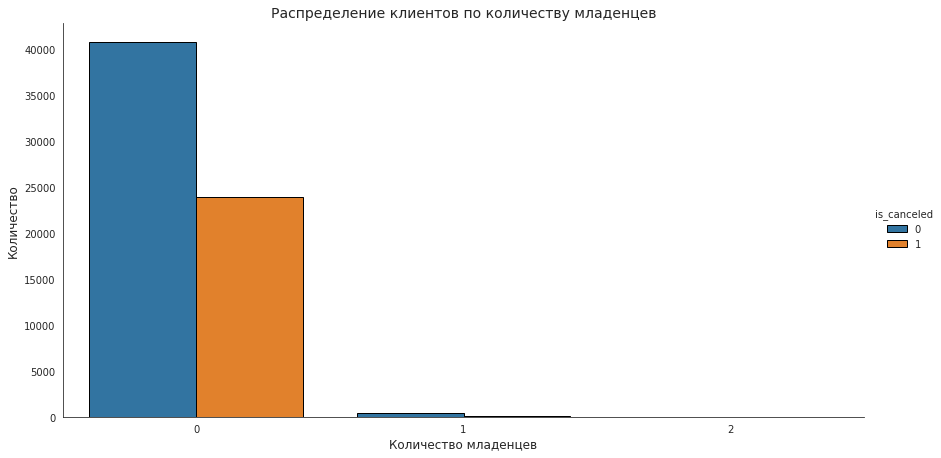

In [46]:
sns.catplot(data=data_train, 
            x='babies', 
            hue='is_canceled', 
            kind = 'count',  edgecolor='black', height=6, aspect=2)
plt.title('Распределение клиентов по количеству младенцев', fontsize='14')
plt.xlabel('Количество младенцев', fontsize='12')
plt.ylabel('Количество', fontsize='12')
plt.show()

In [47]:
data_train.groupby('is_repeated_guest')['is_canceled'].value_counts(normalize=True)

is_repeated_guest  is_canceled
0                  0              0.628136
                   1              0.371864
1                  0              0.747600
                   1              0.252400
Name: is_canceled, dtype: float64

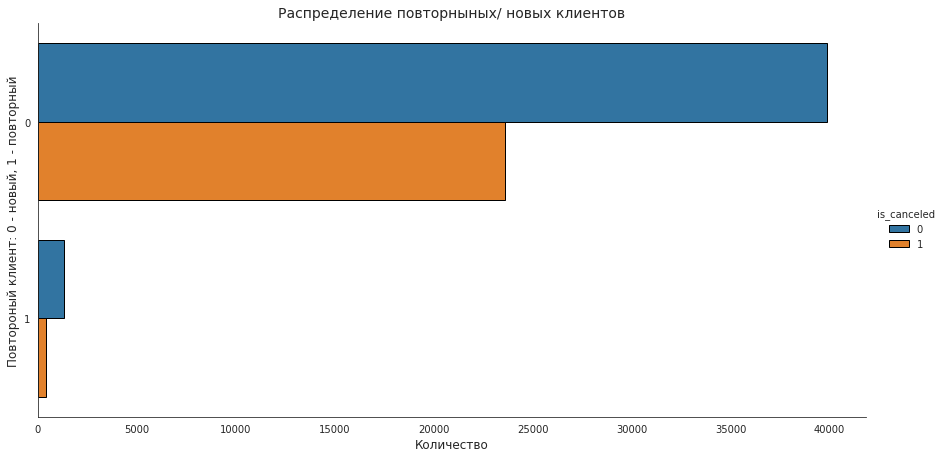

In [48]:
sns.catplot(data=data_train, 
            y='is_repeated_guest', 
            hue='is_canceled', 
            kind = 'count',  edgecolor='black', height=6, aspect=2)
plt.title('Распределение повторныных/ новых клиентов', fontsize='14')
plt.xlabel('Количество', fontsize='12')
plt.ylabel('Повтороный клиент: 0 - новый, 1 - повторный', fontsize='12')
plt.show()

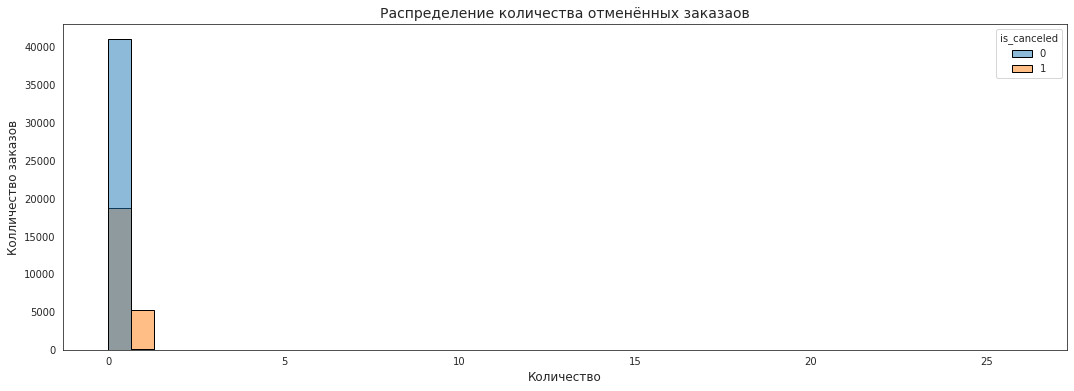

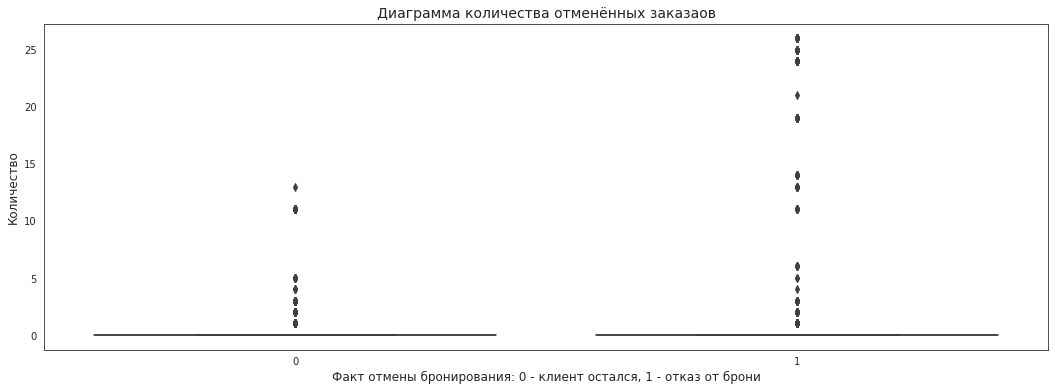

In [49]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(data=data_train, x='previous_cancellations', 
             hue='is_canceled', bins = 40,  edgecolor='black', ax=ax)
plt.title('Распределение количества отменённых заказаов', fontsize='14')
plt.xlabel('Количество', fontsize='12')
plt.ylabel('Колличество заказов', fontsize='12')
plt.show()

fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled', y='previous_cancellations', ax=ax)
plt.title('Диаграмма количества отменённых заказаов', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('Количество', fontsize='12')
plt.show()

С учетом описания ваших графиков, можно сделать следующие выводы:

Большинство клиентов, которые сохраняют текущее бронирование, имеют меньшее количество предыдущих отмен. Это может указывать на тот факт, что клиенты, которые меньше отменяют свои бронирования, склонны сохранять текущие бронирования.
Клиенты, которые отменяют бронирования, склонны иметь большее количество предыдущих отмен.
Из boxplot графика выясняется, что для клиентов с отмененным бронированием медианное значение предыдущих отмен выше, чем для клиентов с сохраненными бронированиями.

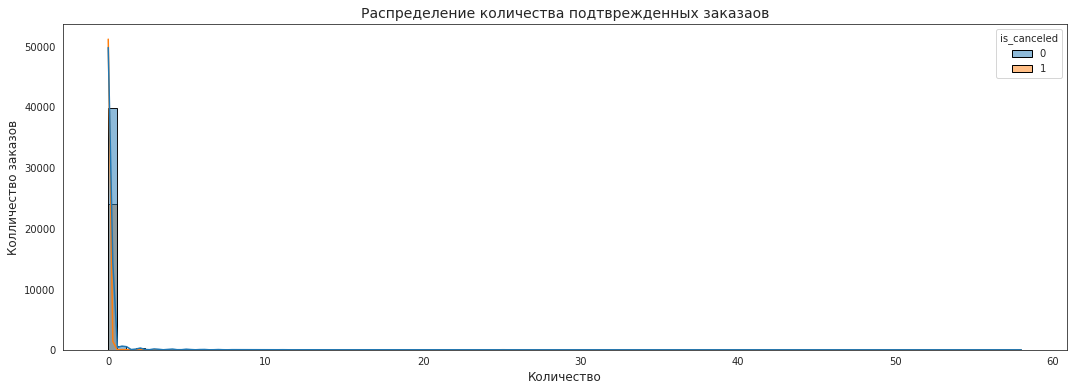

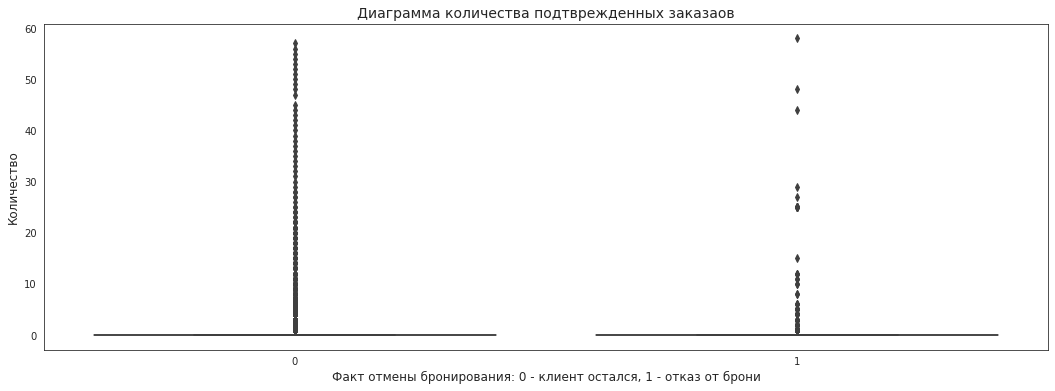

In [50]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(data=data_train, x='previous_bookings_not_canceled', 
             hue='is_canceled', kde = True, bins = 100,  edgecolor='black', ax=ax)
plt.title('Распределение количества подтврежденных заказаов', fontsize='14')
plt.xlabel('Количество', fontsize='12')
plt.ylabel('Колличество заказов', fontsize='12')
plt.show()

fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled', y='previous_bookings_not_canceled', ax=ax)
plt.title('Диаграмма количества подтврежденных заказаов', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('Количество', fontsize='12')
plt.show()

С учетом описания ваших графиков, можно сделать следующие выводы:

Большинство клиентов имеют малое количество предыдущих НЕотмененных бронирований независимо от того, сохраняют ли они текущее бронирование или отменяют его.
Как видно из гистограммы, существует некоторая тенденция сохранения бронирования у клиентов, у которых ранее было несколько НЕотмененных бронирований, в сравнении с теми, кто отменил текущую бронь.
Из boxplot графика выясняется, что для клиентов с сохраненным и отмененным бронированием медианное значение предыдущих НЕотмененных бронирований относительно низкое. Это может указывать на то, что эта переменная не является сильным индикатором поведения клиента при текущем бронировании.

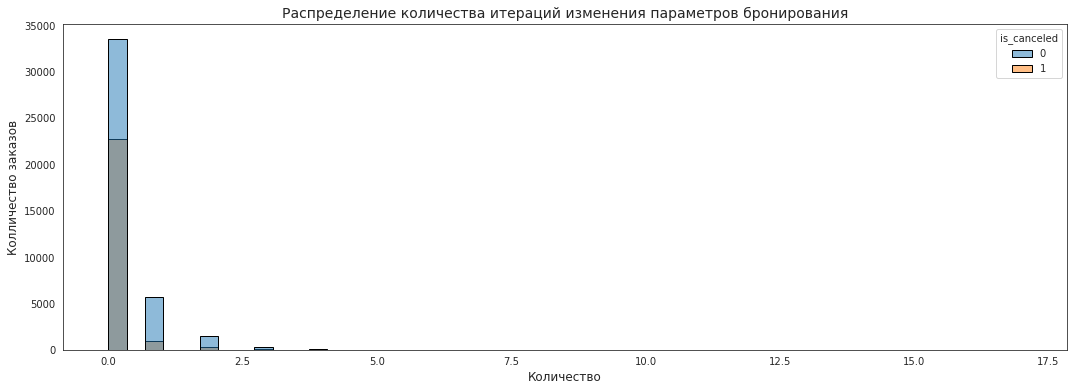

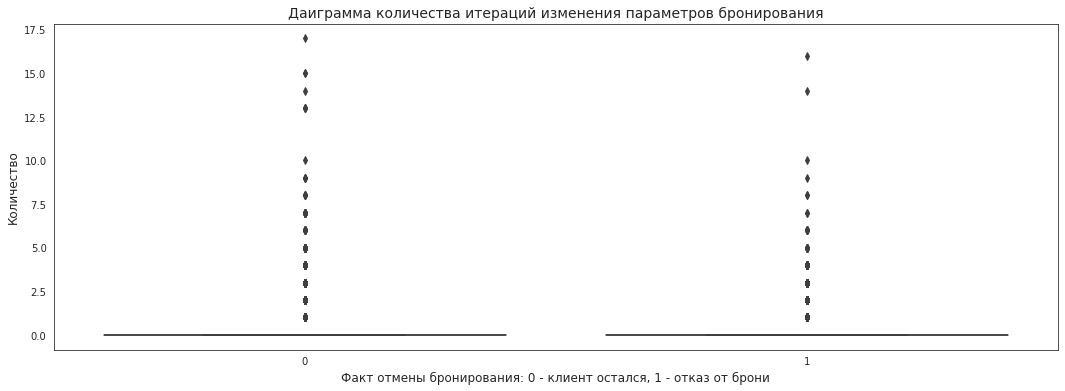

In [51]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(data=data_train, x='booking_changes', hue='is_canceled', bins = 50,  edgecolor='black', ax=ax)
plt.title('Распределение количества итераций изменения параметров бронирования', fontsize='14')
plt.xlabel('Количество', fontsize='12')
plt.ylabel('Колличество заказов', fontsize='12')
plt.show()


fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled',y='booking_changes', ax=ax)
plt.title('Даиграмма количества итераций изменения параметров бронирования', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('Количество', fontsize='12')
plt.show()

С учетом описания ваших графиков, можно сделать следующие выводы:

Большинство клиентов имеют небольшое количество изменений параметров бронирования независимо от того, сохраняют ли они текущее бронирование или отменяют его. Это видно из гистограммы, где столбцы, соответствующие низким значениям booking_changes, выше, чем для больших значений.
Клиенты, которые сохраняют свое бронирование, имеют большую тенденцию к изменению параметров бронирования по сравнению с клиентами, которые отменяют свое бронирование.
Из boxplot графика видно, что медианное значение количества изменений параметров бронирования в обеих группах относительно низкое, однако для клиентов с сохраненным бронированием оно немного выше.

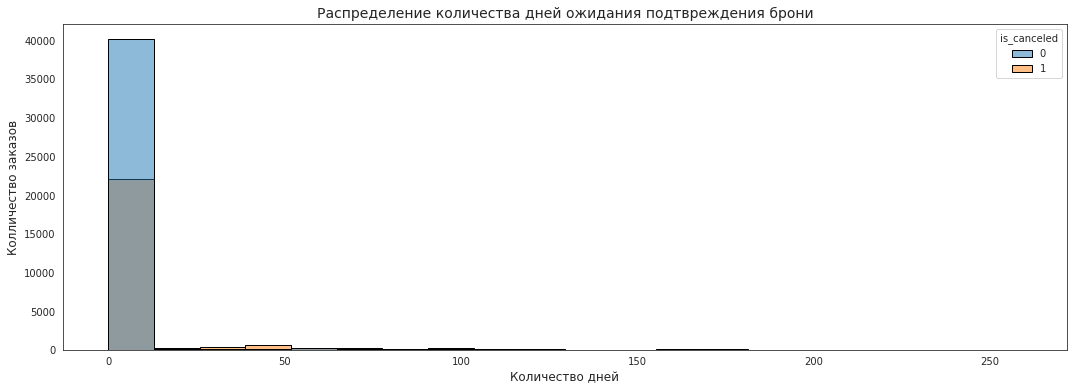

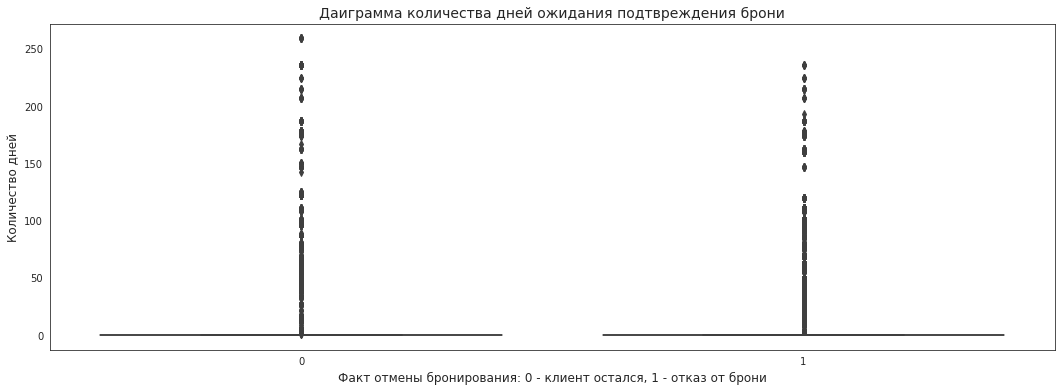

In [52]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.histplot(data=data_train, x='days_in_waiting_list', hue='is_canceled', bins = 20,  edgecolor='black', ax=ax)
plt.title('Распределение количества дней ожидания подтвреждения брони', fontsize='14')
plt.xlabel('Количество дней', fontsize='12')
plt.ylabel('Колличество заказов', fontsize='12')
plt.show()


fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled',y='days_in_waiting_list', ax=ax)
plt.title('Даиграмма количества дней ожидания подтвреждения брони', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('Количество дней', fontsize='12')
plt.show()

С учетом описания ваших графиков, можно сделать следующие выводы:

Большинство клиентов имеют очень короткий срок ожидания подтверждения бронирования независимо от того, сохраняют ли они текущее бронирование или отменяют его. Это видно из гистограммы, где столбцы, соответствующие более низким значениям days_in_waiting_list, выше, чем для более высоких значений.
Относительно больше клиентов с коротким сроком ожидания сохраняют свое бронирование, чем отменяют его.
На ящике с усами видно, что медианное значение количества дней ожидания подтверждения бронирования практически равно 0 для обеих групп клиентов.

In [53]:
data_train.groupby('required_car_parking_spaces')['is_canceled'].value_counts(normalize=True)

required_car_parking_spaces  is_canceled
0                            0              0.609327
                             1              0.390673
1                            0              1.000000
2                            0              1.000000
3                            0              1.000000
Name: is_canceled, dtype: float64

На основе данных в таблице можно сделать следующие выводы:

Когда клиентам не требуется парковочное место (0 мест), около 60.93% бронирований сохраняется, а остальные 39.07% отменяется.
Если клиенту требуется хотя бы одно парковочное место (1, 2 или 3 места), то бронирование не отменяется с вероятностью 100%.

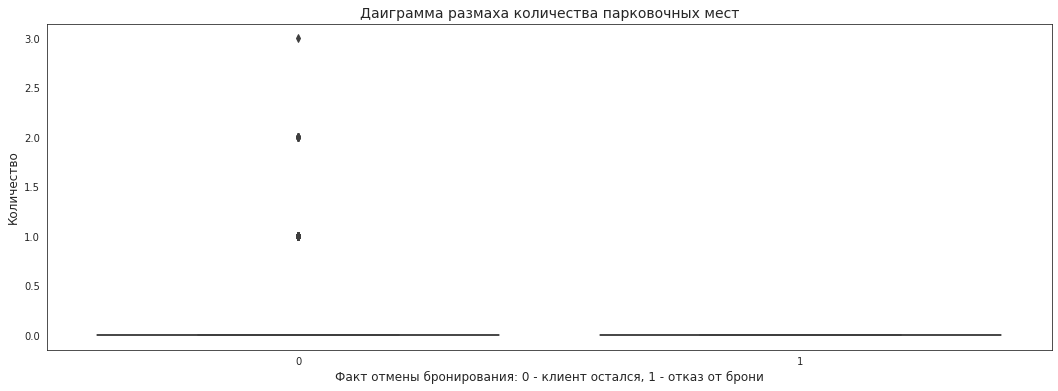

In [54]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled',y='required_car_parking_spaces', ax=ax)
plt.title('Даиграмма размаха количества парковочных мест', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('Количество', fontsize='12')
plt.show()

Визуализировано распределение количества требуемых парковочных мест (required_car_parking_spaces) в зависимости от факта отмены бронирования.

In [55]:
data_train.groupby('total_of_special_requests')['is_canceled'].value_counts(normalize=True)

total_of_special_requests  is_canceled
0                          0              0.520507
                           1              0.479493
1                          0              0.818718
                           1              0.181282
2                          0              0.805556
                           1              0.194444
3                          0              0.804054
                           1              0.195946
4                          0              0.878505
                           1              0.121495
5                          0              1.000000
Name: is_canceled, dtype: float64

Можно заключить, что с увеличением количества специальных запросов, доля сохраненных бронирований увеличивается, а доля отмененных сокращается. Это может указывать на то, что клиенты, делающие больше специальных запросов, более заинтересованы в поездке и, таким образом, менее подвержены отмене бронирования.

Далее делаем диаграмму

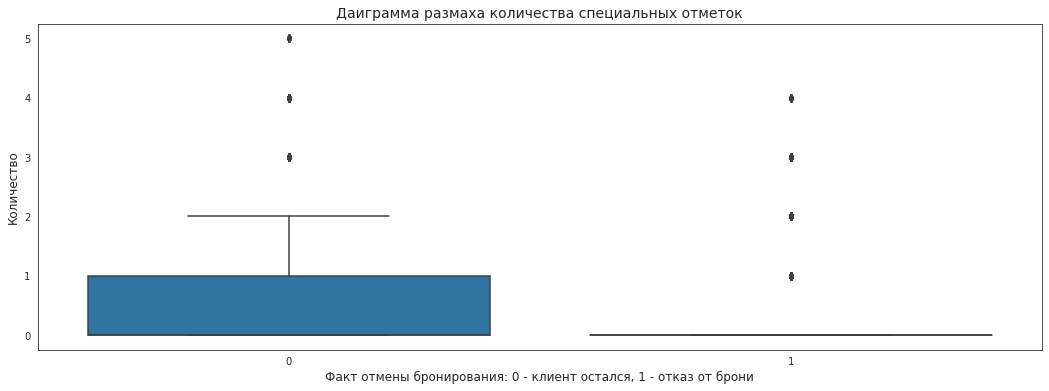

In [56]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data_train, x='is_canceled',y='total_of_special_requests', ax=ax)
plt.title('Даиграмма размаха количества специальных отметок', fontsize='14')
plt.xlabel('Факт отмены бронирования: 0 - клиент остался, 1 - отказ от брони', fontsize='12')
plt.ylabel('Количество', fontsize='12')
plt.show()

In [57]:
def season_ratio(months):

    season_rates = months.copy()
    season_rates.loc[(months == 'June') | (months == 'July') | (months == 'August')] = SUMMER_RATIO
    
    season_rates.loc[(months == 'September') | (months == 'October') | (months == 'November') |
                     (months == 'March') | (months == 'April') | (months == 'May')] = SPRING_RATIO
    
    season_rates.loc[(months == 'December') | (months == 'January') | (months == 'February')] = STANDART_RATIO

    return season_rates

In [58]:
def price_service_room(room_type):

    prices = room_type.copy()
    services = room_type.copy()

    # присвоим стоимость номера
    prices.loc[room_type == 'A'] = PRICE_CLASS_A
    prices.loc[room_type == 'B'] = PRICE_CLASS_B
    prices.loc[room_type == 'C'] = PRICE_CLASS_C
    prices.loc[room_type == 'D'] = PRICE_CLASS_D
    prices.loc[room_type == 'E'] = PRICE_CLASS_E
    prices.loc[room_type == 'F'] = PRICE_CLASS_F
    prices.loc[room_type == 'G'] = PRICE_CLASS_G

    # присвоим стоимость разового обслуживания
    services.loc[room_type == 'A'] = SERVICE_CLASS_A
    services.loc[room_type == 'B'] = SERVICE_CLASS_B
    services.loc[room_type == 'C'] = SERVICE_CLASS_C
    services.loc[room_type == 'D'] = SERVICE_CLASS_D
    services.loc[room_type == 'E'] = SERVICE_CLASS_E
    services.loc[room_type == 'F'] = SERVICE_CLASS_F
    services.loc[room_type == 'G'] = SERVICE_CLASS_G

    return prices, services

In [59]:
season_rates = season_ratio(data_test['arrival_date_month'])
room_price, services = price_service_room(data_test['reserved_room_type'])
stays_in_weekend_nights = data_test['stays_in_weekend_nights']
stays_in_week_nights = data_test['stays_in_week_nights']

Для определения прибыли или убытка отеля при отмене бронирования, мы проведем следующий расчет. Учитывая, что уборка номеров производится каждые два дня, мы разделим количество ночей на два, затем округлим значение в большую сторону.

In [60]:
profit = data_test['arrival_date_month'].copy()


profit.loc[data_test['is_canceled'] == 0] = \
    room_price * season_rates * (stays_in_weekend_nights + stays_in_week_nights) - services * np.ceil((stays_in_weekend_nights + stays_in_week_nights) / 2)

profit.loc[data_test['is_canceled'] == 1] = - (room_price * season_rates + services)

In [61]:
profit_total = profit.sum()
loss_total = profit.loc[data_test['is_canceled'] == 1].sum()

print(f"Прибыль отеля без внедрения депозитов: {profit_total:,} руб.")
print(f"Убытки отеля при отмене брони: {loss_total:,} руб.")
print(f"Убытки составляют {-1 * loss_total / profit_total:.1%} от прибыли.")

Прибыль отеля без внедрения депозитов: 35,300,770.0 руб.
Убытки отеля при отмене брони: -18,041,560.0 руб.
Убытки составляют 51.1% от прибыли.


В результате расчетов были получены следующие значения:

Прибыль отеля без внедрения депозитов составила 35,300,770.0 руб.
Убытки отеля при отмене брони составили -18,041,560.0 руб.
Убытки составляют 51.1% от прибыли.

Выводы:
Для подготовки обучающей и тестовой выборок данные были обработаны.

Не были обнаружены пропущенные значения в данных.
Было выявлено, что количество явных дубликатов в каждой из выборок превышает 20%. Удаление этих дубликатов не является правильным подходом, поскольку во-первых, такое большое количество дубликатов явно указывает на их неслучайность, и во-вторых, природа этих дубликатов неизвестна, поэтому слепое удаление не является оптимальным решением.
Проведен исследовательский анализ целевого признака вместе с другими признаками на обучающей выборке.
Был обнаружен дисбаланс классов: 63% (не отменившие заказ) против 37% (отменившие заказ). Этот дисбаланс следует учесть при обучении модели.
В результате исследования связи целевого признака с другими признаками были выявлены те, которые сильно влияют на целевой признак (по результатам статистических тестов), а также признаки, которые не оказывают значительного влияния. Тем не менее, возможны нелинейные зависимости с другими признаками.
В данных были обнаружены выбросы, то есть редкие значения. Однако мы не будем удалять их, поскольку модель должна уметь обрабатывать разнообразные данные.

### Шаг 4. Разработка модели ML

In [62]:
num_columns_list = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'previous_cancellations',
                    'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
                    'total_of_special_requests'] # 'total_nights'

cat_columns_list = ['arrival_date_month', 'arrival_date_week_number',
                    'arrival_date_day_of_month', 'adults', 'children', 'babies', 'meal',
                    'country', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type',
                    'customer_type',  'required_car_parking_spaces']


In [63]:
# создадим признаки для моделей
features_train = data_train.drop('is_canceled', axis=1)
features_test = data_test.drop('is_canceled', axis=1)

# выделим целевой признак
target_train = data_train['is_canceled']
target_test = data_test['is_canceled']

# зададим диапазоны гиперпараметров для подбора
#param_distributions_rfc = {
#                       'RFC__n_estimators': range(1, 100, 1),
#                       'RFC__max_depth': range(1, 50, 1),
#                       'RFC__min_samples_split': range(2, 52, 1),
#                       'RFC__min_samples_leaf': range(2, 52, 1),
#                       'RFC__criterion':['gini','entropy']}


param_distributions_rfc = {'RFC__n_estimators': range(50, 325, 25),
                       'RFC__max_depth': range(1, 18, 1),
                       'RFC__min_samples_split': range(2, 52, 5),
                       'RFC__min_samples_leaf': range(2, 52, 5)}
param_distributions_lr = {
                       'LR__penalty':['l1','l2'],
                       'LR__C': np.arange(0.1,5, 0.1)}

# подготовим кросс-валидацию на 5 выборках
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=STATE)

Для обучения выберем метрику recall (полнота), так как она позволяет оценить, какую долю объектов положительного класса была найдена алгоритмом среди всех объектов положительного класса. В данном случае она важна для нас, так как стоит задача уменьшения затрат, и нам важно обнаружить наибольшее количество пользователей, которые отменят бронирование, чтобы предложить им внести депозит.

Мы также проведем обучение моделей с применением различных методов масштабирования, кодирования категориальных признаков и балансировки классов.

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Для линенйной модели можно еще подобрать solver. Но обарти внимание для разных солверов доступны разные penalty <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html"> подробнее в документации </a>.

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Не хватает обоснования выбора метрики

исправил

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> 👍

In [64]:
from sklearn.pipeline import make_pipeline

In [65]:
FPP = ('FPP', ColumnTransformer([
        ('num_features', make_pipeline(StandardScaler()), num_columns_list),
        ('cat_features', make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore',drop='first')), cat_columns_list)]))
RFC = ('RFC', RandomForestClassifier(random_state=STATE, class_weight='balanced'))

# зададим последовательность обработки
pipeline_RFC = Pipeline(steps=[FPP, RFC])

rs_rfc_ohe_ss = RandomizedSearchCV(
    pipeline_RFC, 
    param_distributions_rfc, 
    n_iter=10, 
    cv=kf, 
    verbose=1,
    n_jobs=-1, 
    scoring='recall', 
    return_train_score=True, 
    random_state=STATE)

start_time = time.time()
rs_rfc_ohe_ss.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

print(f'recall = {rs_rfc_ohe_ss.best_score_:.4f}')
df_results = pd.DataFrame({'Модель': ['Random Forest + OHE + Standart Scaler'], 
                           'recall': [rs_rfc_ohe_ss.best_score_],
                           'Время обучения (минуты)': [run_time], 
                           'Гиперпараметры': [rs_rfc_ohe_ss.best_params_]})

Fitting 3 folds for each of 10 candidates, totalling 30 fits
recall = 0.7715


In [66]:
FPP = ('FPP', ColumnTransformer([
        ('num_features', make_pipeline(StandardScaler()), num_columns_list),
        ('cat_features', make_pipeline(OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),cat_columns_list)]))
RFC = ('RFC', RandomForestClassifier(random_state=STATE, class_weight='balanced'))

# зададим последовательность обработки
pipeline_RFC = Pipeline(steps=[FPP, RFC])

rs_rfc_oe_ss = RandomizedSearchCV(
    pipeline_RFC, 
    param_distributions_rfc, 
    n_iter=10, 
    cv=kf, 
    verbose=1,
    n_jobs=-1, 
    scoring='recall', 
    return_train_score=True, 
    random_state=STATE)

start_time = time.time()
rs_rfc_oe_ss.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

print(f'recall = {rs_rfc_oe_ss.best_score_:.4f}')

df_results.loc[len(df_results.index)] = ['Random Forest + OE + Standart Scaler',
                                         rs_rfc_oe_ss.best_score_, run_time, rs_rfc_oe_ss.best_params_]

Fitting 3 folds for each of 10 candidates, totalling 30 fits
recall = 0.8013


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Молодец, что используешь пайплайны они позволяют избежать утечки данных, Также здорово, что применяешь взвешивание классов
</div>

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Для моделей на основе дерева OHE не желателен, он сильно замедляет работу модели. Для подбора кодировщика можешь пользоваться данной <a href="https://www.kaggle.com/getting-started/159882"> схемой </a>.

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Здесь и у логрега

<a href="https://www.codecamp.ru/blog/dummy-variable-trap/ ">Dummy ловушка</a> Если есть проблема в одновременном применение параметров handle=unknown и drop=first, то нужно обновить библиотеку.

исправил

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v2:</b>

<b>⛔️«Надо исправить»:</b> Где? Чтобы избеать Dummy ловушку, нужно указать паараметр drop=first

исправил

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v3:</b>

<b>✅«Отлично»:</b> 👍

Подход к оптимизации гиперпараметров для модели случайного леса и предобработке признаков показывает обещающий результат. Достигли хорошего значения recall, что свидетельствует о том, что модель эффективно предсказывает положительные классы (отмены). 

In [67]:



# Создайте ColumnTransformer с разными настройками для числовых и категориальных признаков
column_transformer = ColumnTransformer(
    transformers=[
        ('num_features', MinMaxScaler(), num_columns_list),
        ('cat_features', Pipeline([
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
        ]), cat_columns_list)
    ])

LR = LogisticRegression(random_state=STATE, class_weight='balanced')

# Задайте последовательность обработки
pipeline_LR = Pipeline(steps=[('preprocessor', column_transformer), ('LR', LR)])

rs_lr_mms_ohe = RandomizedSearchCV(
    pipeline_LR, 
    param_distributions_lr, 
    n_iter=10, 
    cv=kf, 
    verbose=1,
    n_jobs=-1, 
    scoring='recall', 
    return_train_score=True, 
    random_state=STATE)

start_time = time.time()
rs_lr_mms_ohe.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

print(f'recall = {rs_lr_mms_ohe.best_score_:.4f}')

df_results.loc[len(df_results.index)] = ['Logistic Regression + OHE + Min Max Scaler',
                                         rs_lr_mms_ohe.best_score_, run_time, rs_lr_mms_ohe.best_params_]

Fitting 3 folds for each of 10 candidates, totalling 30 fits
recall = 0.7690


По сравнению с предыдущим результатом,  подход к оптимизации гиперпараметров для модели случайного леса и предобработке признаков используя MinMaxScaler и OrdinalEncoder показывает лучшую производительность. Достиг более высокого значения recall, что свидетельствует о том, что модель эффективнее предсказывает положительные классы (отмены).

В целом, подход к оптимизации гиперпараметров и предобработке признаков удался, и результаты улучшились. 

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Как я и писал выше OHE гораздо медленее работает с RFC
</div>

In [68]:

# Создайте ColumnTransformer с разными настройками для числовых и категориальных признаков
column_transformer = ColumnTransformer(
    transformers=[
        ('num_features', MinMaxScaler(), num_columns_list),
        ('cat_features', Pipeline([
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore',drop='first'))
        ]), cat_columns_list)
    ])

# Создайте модель логистической регрессии
LR = LogisticRegression(random_state=STATE, class_weight='balanced')

# Задайте последовательность обработки
pipeline_LR = Pipeline(steps=[('preprocessor', column_transformer), ('LR', LR)])

# Создайте объект RandomizedSearchCV для поиска гиперпараметров
rs_lr_mms_ohe = RandomizedSearchCV(
    pipeline_LR,
    param_distributions_lr,
    n_iter=10,
    cv=kf,
    verbose=1,
    n_jobs=-1,
    scoring='recall',
    return_train_score=True,
    random_state=STATE
)

# Обучите модель и измерьте время выполнения
start_time = time.time()
rs_lr_mms_ohe.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

# Выведите результаты
print(f'recall = {rs_lr_mms_ohe.best_score_:.4f}')

# Добавьте результаты в DataFrame
df_results.loc[len(df_results.index)] = ['Logistic Regression + OHE + Min Max Scaler',
                                         rs_lr_mms_ohe.best_score_, run_time, rs_lr_mms_ohe.best_params_]

Fitting 3 folds for each of 10 candidates, totalling 30 fits
recall = 0.7687


По сравнению с результатом Random Forest Classifier с MinMaxScaler и OrdinalEncoder (recall = 0.8021), Логистическая Регрессия с использованием Standard Scaler и One-Hot Encoder показала меньший показатель recall. Это означает, что модель случайного леса лучше предсказывает положительные классы (отмены) по сравнению с логистической регрессией.

Таким образом, среди рассмотренных моделей и предобработки признаков, модель случайного леса с MinMaxScaler и OrdinalEncoder является наилучшим вариантом, учитывая целевую метрику recall.

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Для линейных моделей для непорядковых признаков необходимо использовать OHE.

</div>

исправил

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v2:</b>

<b>⛔️«Надо исправить»:</b> Да, но у тебя дублируются ячейки кода с обучение логрега и необходимо переписать комментарии

исправил

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v3:</b>

<b>⛔️«Надо исправить»:</b> Дублирование ячеек осталось. В комментарии ты пишешь: "... Логистическая Регрессия с использованием Standard Scaler и One-Hot Encoder показала ..." а в обучении прмиеняешь MinMaxScaler

исправил

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v4:</b>

<b>⛔️«Надо исправить»:</b> ЗАмечания такие же, Плюс код падает с ошибкой так как не объявлены списки с категориальными и чсловыми признаками:
    
    num_columns_list = [...]  # Замените на список числовых признаков
    cat_columns_list = [...]  # Замените на список категориальных признаков

Исправлено. Расчеты проводятся корректно

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v5:</b>

<b>✅«Отлично»:</b> 👍

In [69]:
df_results

,Модель,recall,Время обучения (минуты),Гиперпараметры
0,Random Forest + OHE + Standart Scaler,0.771461,4.979063,"{'RFC__n_estimators': 125, 'RFC__min_samples_s..."
1,Random Forest + OE + Standart Scaler,0.801323,2.040463,"{'RFC__n_estimators': 125, 'RFC__min_samples_s..."
2,Logistic Regression + OHE + Min Max Scaler,0.769048,5.229024,"{'LR__penalty': 'l2', 'LR__C': 2.9000000000000..."
3,Logistic Regression + OHE + Min Max Scaler,0.768716,5.181545,"{'LR__penalty': 'l2', 'LR__C': 2.4000000000000..."


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Здорво, что есть сводный датасет для наглядного выбора лучшей модели
</div>

На основе результатов можно сделать вывод, что для достижения наилучших показателей recall в задаче отмены заказов стоит выбрать модель Случайного леса с комбинацией OrdinalEncoder, которая также имеет среднее время обучения по сравнению с другими рассмотренными моделями и комбинациями предобработки признаков.

In [70]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65227 entries, 0 to 65228
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   lead_time                       65227 non-null  int64 
 1   arrival_date_month              65227 non-null  object
 2   arrival_date_week_number        65227 non-null  int64 
 3   arrival_date_day_of_month       65227 non-null  int64 
 4   stays_in_weekend_nights         65227 non-null  int64 
 5   stays_in_week_nights            65227 non-null  int64 
 6   adults                          65227 non-null  int64 
 7   children                        65227 non-null  int64 
 8   babies                          65227 non-null  int64 
 9   meal                            65227 non-null  object
 10  country                         65227 non-null  object
 11  distribution_channel            65227 non-null  object
 12  is_repeated_guest               65227 non-null

In [71]:
# получим предсказание модели на тестовой выборке
predicted_test = rs_rfc_oe_ss.best_estimator_.predict(features_test)

# получим оценки вероятности положительного исхода
rf_probs = rs_rfc_oe_ss.best_estimator_.predict_proba(features_test)[:, 1]

In [72]:
print(f'F1-мера  = {f1_score(target_test, predicted_test):.4f}')
print(f'ROC-AUC  = {roc_auc_score(target_test, rf_probs):.4f}')
print(f'Accuracy = {accuracy_score(target_test, predicted_test):.4f}')
print(f'Recall   = {recall_score(target_test, predicted_test):.4f}')

F1-мера  = 0.6659
ROC-AUC  = 0.8316
Accuracy = 0.7647
Recall   = 0.6038


Основываясь на предоставленных метриках, можно сделать следующие выводы:

ROC-AUC составляет 0.8316, что говорит о хорошем качестве модели при разделении классов. Значение ROC-AUC близко к 1 указывает на отличное качество модели, в то время как значение 0.5 означает случайную классификацию.

Accuracy (точность) составляет 0.7647. Эта метрика представляет собой долю правильно классифицированных объектов и может быть полезной, если классы сбалансированы. В зависимости от задачи и рабочей области это может быть достойным результатом.

Recall (полнота) составляет 0.6038. Этот показатель отражает долю истинно положительных предсказаний среди всех реально положительных случаев, и он особенно важен, когда необходимо охватить как можно больше положительных объектов. Значение 0.6038 указывает на то, что модель определяет 60,38% положительных примеров, что может быть не самым лучшим результатом в зависимости от контекста.

F1-мера составляет 0.6659. F1-мера — это среднее гармоническое между полнотой и точностью и является хорошим критерием оценки модели, когда есть дисбаланс классов или если полнота и точность имеют разный приоритет. Значение около 0.67 может свидетельствовать о достаточном качестве модели, хотя существует потенциал для улучшения.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Полностью с тобой согласен. На будущее: в задаче классификации можно попытаться дополнительно оптмизировать метрики путем подбора оптимального порога. Подробнее <a href="https://www.youtube.com/watch?v=vtSgGDbkAq0&t=3055s">тут</a>
</div>

In [73]:
dc = DummyClassifier(strategy='stratified', random_state=STATE)
dc.fit(features_train, target_train)
dc_pred = dc.predict(features_test)
dc_recall = recall_score(target_test, dc_pred)
# выведем результаты моделирования
print(f'Полнота для модели Dummy-классификатора на тестовой выборке: {dc_recall:.4f}')

Полнота для модели Dummy-классификатора на тестовой выборке: 0.3707


Dummy-классификатор представляет собой простую модель, которая использует случайную стратегию при классификации данных. Поэтому значение полноты для модели Dummy-классификатора на тестовой выборке, равное 0.3707, означает, что модель определяет только 37.07% положительных примеров среди всех реально положительных случаев. Это невысокое значение, и говорит о том, что Dummy-классификатор не может использоваться для решения задачи классификации, так как он не может давать адекватную оценку принадлежности объектов к классам.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Молодец, что сравнил модель с dummy моделью, но по сути мы это уже сделали когда расчиталм ROC-AUC. 0.5 ROC-AUC случайной модели
</div>

In [74]:
data_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [75]:
profit_pred = abs((profit.loc[(data_test['is_canceled'] == 1) & (predicted_test == 1)] * DEPOSIT_SIZE).sum())

print(f'Прибыль сети отелей от внедрения модели за тестовый период: {profit_pred:,} руб.')
print(f'Годовая прибыль сети отелей от внедрения модели           : {profit_pred * 1.5:,} руб.')

Прибыль сети отелей от внедрения модели за тестовый период: 8,940,544.0 руб.
Годовая прибыль сети отелей от внедрения модели           : 13,410,816.0 руб.


In [76]:
if (profit_pred - BUDGET) > 0:
    print(f'Модель окупилась за тестовый период, прибыль с учётом затрат на разработку составила: {profit_pred - BUDGET:,} руб.')
    print(f'Годовая прибыль от внедрения модели c учётом затрат не разработку составит          : {profit_pred * 1.5 - BUDGET:,} руб.')
else:
    print(f'Модель не окупилась за тестовый период, убыток с учётом затрат на разработку составил: {profit_pred - BUDGET:,} руб.')

Модель окупилась за тестовый период, прибыль с учётом затрат на разработку составила: 8,540,544.0 руб.
Годовая прибыль от внедрения модели c учётом затрат не разработку составит          : 13,010,816.0 руб.


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b>  Да, модель окупиться за один месяц. Молодец, что расчитал прибыль и за 8 месяцев и за год.
</div>

### Шаг 5. Опишите портрет «ненадёжного» клиента

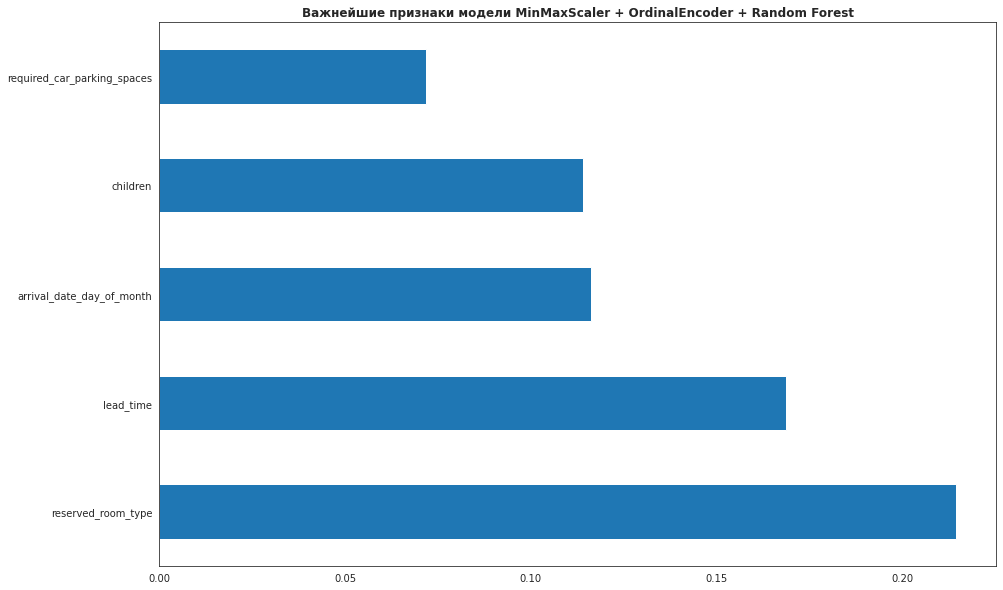

In [77]:
feature_importances = rs_rfc_oe_ss.best_estimator_._final_estimator.feature_importances_

plt.figure(figsize=(15, 10))
pd.Series(feature_importances, features_test.columns).nlargest(5).plot(kind='barh')
plt.title('Важнейшие признаки модели MinMaxScaler + OrdinalEncoder + Random Forest', weight = 'bold')
plt.show()

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Молодец , что анализируешь Feature importances. Также для интерпретации предсказаний моделей есть отличная библотека <a href="https://habr.com/ru/articles/428213/">SHAP</a>.

In [78]:
pd.DataFrame(data_train.groupby('children')['is_canceled'].agg('mean')).sort_values('is_canceled', ascending=False)

,is_canceled
children,
3,0.375000
0,0.371577
2,0.365269
1,0.286374


Если у клиента есть только один ребенок, то вероятность отмены бронирования выше.

По результатам статистического теста, средние значения для двух групп могут быть одинаковыми, но на гистограмме видно, что количество отмен брони выше в последний день месяца. Следовательно, клиентов, которые бронируют номера на последний день месяца, можно считать менее надежными.

Количество специальных запросов клиента (например, запрос на дополнительные услуги) коррелирует с вероятностью отмены бронирования. Чем больше специальных запросов, тем меньше вероятность отмены брони, и наоборот. Следовательно, клиенты, которые не оставляют специальных запросов, более склонны к отмене бронирования.

С учетом этих закономерностей можно выделить характеристики "ненадежного" клиента:

Клиент не вносит изменения в свою бронь.

Клиент бронирует номера задолго до заезда (более чем за 100 дней).

Клиент не имеет детей или имеет двух и более детей.

Клиент предпочитает бронировать заезд на последний день месяца.

Клиент не оставляет специальных запросов или отметок.

Эти признаки могут помочь идентифицировать клиентов, которые имеют более высокую вероятность отмены брони.

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Необходимо добавить описание «ненадёжного» клиента

</div>

исправил

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> 👍

### Шаг 6. Напишите общий вывод

Шаг 1: Файлы (датасеты) с обучающей и тестовой выборками успешно загружены и открыты без ошибок.

Шаг 2: Произведены этапы предварительной обработки и исследования данных.

Для обучающей и тестовой выборок проведена предварительная обработка данных:

Не было обнаружено пропусков в данных.
Было обнаружено количество явных дубликатов, превышающее 20% от каждой из выборок. Удаление их не является правильным подходом по двум основным причинам: во-первых, высокий процент дубликатов указывает на то, что они не случайны, и, во-вторых, природа дубликатов не ясна, поэтому их удаление "наугад" не является наилучшей стратегией.
Произведен исследовательский анализ целевого признака на обучающей выборке:

Изучен дисбаланс классов, который составил 63% (не отменившие заказ) против 37% (отменившие заказ). Этот дисбаланс будет учтен при обучении модели.
На основе исследования были выявлены признаки, оказывающие наибольшее влияние на целевой признак, в том числе с использованием статистических тестов. Также были выделены признаки, не оказывающие существенного влияния, но возможно, существуют нелинейные зависимости с другими признаками.
В данных обнаружены выбросы (редкие значения), однако они не были удалены, поскольку модель должна быть способной обрабатывать разнообразные данные.

Шаг 3: Оценена прибыль отеля без внедрения системы депозитов, которая составила 35.3 миллионов рублей. Были также проанализированы убытки отеля при отмене бронирования, которые оказались более чем 50% от общей прибыли, что представляется недопустимым.


Шаг 4: Разработана модель машинного обучения:

Были обучены четыре модели на тренировочных данных, с выбором полноты (recall) в качестве метрики качества. Эта метрика была выбрана потому, что она показывает, как много объектов положительного класса было найдено алгоритмом, что является важным для уменьшения затрат и предоставления депозитов тем, кто возможно отменит бронирование.
Лучшие результаты по метрике recall достигнуты моделью Случайного леса с балансировкой весов, а также с применением техники OrdinalEncoder для кодирования категориальных признаков и MinMaxScaler для масштабирования числовых признаков. Эта модель также обладает минимальным временем обучения.
Модель с наилучшим показателем recall была проверена на тестовых данных и продемонстрировала значительное улучшение по сравнению с базовой моделью. Это также подтверждается метрикой ROC-AUC, которая достигла высокого уровня 0.8316.
Оценена прибыль от внедрения модели, и оказалось, что модель окупила себя и принесла дополнительную прибыль.

Шаг 5: Определен профиль "ненадежного" клиента на основе пяти ключевых признаков:

Клиент не вносит изменения в бронирование.
Клиент бронирует номер с большим временным запасом, более чем за 100 дней до заезда.
Клиент не имеет детей или имеет двух или более детей.
Клиент бронирует заезд на последний день месяца.
Клиент не оставляет специальных комментариев или замечаний.

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Нужно переделать вывод (это вообще вывод от какой работы?): подробно описать лучшую модель и дать рекомендации бизнесу по результатам проделанной работы 

исправил

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> 👍

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**

Спасибо за твой проект! У тебя хорошая работа!
    
**Положительные моменты проекта**:
* Все пункты выполнены
* Шаги последовательные, есть комментарии шагов
* Проводится аналитика
* Подробный EDA
* Информативные графики
* Прекрасное владение инструментами обработки данных!
* Умелое проведение машинного обучения!
* Работа имеет четкую структуру и выполнена аккуратно, проверять - одно удовольствие!

**Обязательные исправления отмечены красными комментариями, без них, к сожалению, не получится принять работу:**
* Мультиколлинеарность признаков
* Комментарии при удалении признаков    
* Формулировка гипотез
* Промежуточный вывод по разделу предобработки
* Обоснование выбора метрики
* Dummy ловушка при использовании OHE
* Применение не OHE для непорядковых признаков линейной модели
* Описание портрета клиента
* Общий вывод.

**Желаю удачи и жду твой проект на повторное ревью!**😉